#PC3

**Cuantización de vectores y regularización en RNNs para mitigar el problema del gradiente desaparecido**

**Descripción:** Combina técnicas de word vector quantization con métodos de regularización en
RNNs para abordar el problema del gradiente desvanecido, mejorando el entrenamiento de
redes profundas.
Componentes clave:
- Word Vector Quantization
- Regularización en RNNs
- Problema del gradiente desaparecido

**Componente de código:** Implementación en PyTorch de una RNN que aplica cuantización de vectores y técnicas de regularización (como dropout o L2) para una tarea de predicción de secuencia.

## PyWavelet

Se emplea la transformada Wavelet discreta para cuantizar los embeddings de cada palabra del corpus

La transformada wavelet discreta convierte una señal de entrada y la reduce a dos arrays de coeficientes de mitad longitud que la de la señal original

Se realiza la siguiente operación de convolución

$$
y[n] = (x*g)[n] = \sum^{\infty}_{k=-\infty} = x[k]g[n-k]
$$

Donde $g$ es la función wavelet base usada para la transformación

Se importa la librería `pywavelet` que contiene funciones wavelet implementadas

Referencia: https://aclanthology.org/2024.findings-acl.945.pdf

In [ ]:
!pip install pywavelets datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pywt

## Tokenizer

Tokenizer usado para suprimir stopwords y palabras con un mínimo de frecuencia en el corpus usado

In [ ]:
import re
from typing import List
import collections
import numpy as np

#INPUT -> List[Str] (lista de textos en el corpus)
#OUTPUT -> List[List[Str] (tokens por cada texto en el corpus)]
class Tokenizer:
  def __init__(self):
    """
    Inicializa el tokenizador con un vocabulario vacío y una lista vacía de tokens.
    Se predefinen stopwords para eliminar del corpus
    """
    self.tokens = []
    self.vocab = collections.Counter()
    self.stopwords = [
    # Stopwords en español
    "a", "al", "algo", "algunos", "ante", "antes", "como", "con", "contra", "cual", "cuando",
    "de", "del", "desde", "donde", "durante", "e", "el", "ella", "ellas", "ellos", "en",
    "entre", "era", "erais", "eran", "eras", "eres", "es", "esa", "esas", "ese", "eso",
    "esos", "esta", "estaba", "estado", "estáis", "estamos", "están", "estar", "estas",
    "este", "esto", "estos", "estoy", "etc", "fue", "fueron", "fui", "fuimos", "ha", "había",
    "habéis", "habíamos", "hace", "hacemos", "hacen", "hacer", "haces", "hago", "han",
    "has", "hasta", "hay", "he", "la", "las", "le", "les", "lo", "los", "me", "mi", "mis",
    "mucho", "muy", "nada", "ni", "no", "nos", "nosotros", "nuestra", "nuestro", "o", "os",
    "otra", "otro", "para", "pero", "poco", "por", "porque", "qué", "que", "quien",
    "quienes", "se", "si", "sin", "sobre", "sois", "solamente", "solo", "son", "su",
    "sus", "también", "tanto", "te", "tenemos", "tengo", "ti", "tienen", "toda",
    "todas", "todo", "todos", "tu", "tus", "un", "una", "unas", "uno", "unos", "vosotros",
    "vuestra", "vuestro", "ya", "yo",

    # Stopwords en inglés
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any",
    "are", "aren't", "as", "at", "be", "because", "been", "before", "being", "below",
    "between", "both", "but", "by", "can", "can't", "cannot", "could", "couldn't", "did",
    "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", "each", "few",
    "for", "from", "further", "had", "hadn't", "has", "hasn't", "have", "haven't", "having",
    "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself",
    "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't",
    "it", "it's", "its", "itself", "let's", "me", "more", "most", "mustn't", "my", "myself",
    "no", "nor", "not", "of", "off", "on", "once", "only", "or", "other", "ought", "our",
    "ours", "ourselves", "out", "over", "own", "same", "shan't", "she", "she'd", "she'll",
    "she's", "should", "shouldn't", "so", "some", "such", "than", "that", "that's", "the",
    "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they",
    "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too",
    "under", "until", "up", "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've",
    "were", "weren't", "what", "what's", "when", "when's", "where", "where's", "which", "while",
    "who", "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", "you", "you'd",
    "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"
    ]


  def tokenize(self, corpus: List[str], min_freq=1, stopwords=False):
    """
    Función que tokeniza el corpus y obtiene el vocabulario conjunto de cada documento
    Retorna:
        List[List[Str] (tokens por cada texto en el corpus)]
    """

    tokens = []
    for text in corpus:
      text = re.sub(r'http[s]*?:\/\/\S+|\[http[^\]]+\]', "<URL>", text)    #URLs
      text = re.sub(r'(?:[A-Z]\.)+', "<ACRONYM>", text)

      text = re.sub(r'\S*\d\S*', '<NUM>', text)      # Números con decimales opcionales y %

      text = re.sub(r'[\]\[\,\;\"\'\?\(\)\:\-\_\`]', "", text)
      text = re.sub(r'[^\w<>]', ' ', text)
      if stopwords:
          text = [word for word in text.lower().split() if word not in self.stopwords]
      else:
          text = text.lower().split()
      tokens.append(text)
      self.vocab.update(text)

    tokens = [[word for word in text if self.vocab[word] >= min_freq] for text in tokens]
    self.vocab = collections.Counter({word: count for word, count in self.vocab.items() if count >= min_freq})

    self.tokens = tokens

    return tokens


## Dataset

Se usa el corpus de imdb para poder procesar los reviews y usarlos para predecir las palabras encontradas en ellos

In [ ]:
!pip install datasets

In [ ]:
import numpy as np
from datasets import load_dataset
from collections import defaultdict
import re

# Cargar el dataset IMDB de Hugging Face
dataset = load_dataset("imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
corpus = list(dataset["train"]["text"][:500])
tokenizer = Tokenizer()
tokens = tokenizer.tokenize(corpus, min_freq=5, stopwords=True)

In [ ]:
dataset["train"]["text"][1]

'"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the s

## Embedding

El embedding se realiza con el modelo `FastText`, el cual permite un entrenamiento rápido y retorna embeddings incluso para palabras que no se encuentran en el vocabulario

In [ ]:
from gensim.models import FastText

model = FastText(sentences=tokens, vector_size=50, window=5, min_count=1, workers=4)
word = 'hello' # can be out of vocabulary
embedding = model.wv[word]

In [ ]:
model.wv.most_similar(model.wv["movie"])

[('movie', 1.0000001192092896),
 ('movies', 0.9999831318855286),
 ('bmovie', 0.9999772906303406),
 ('moved', 0.9999651312828064),
 ('recent', 0.9999585151672363),
 ('stupid', 0.9999581575393677),
 ('move', 0.9999575018882751),
 ('want', 0.9999569654464722),
 ('moves', 0.9999565482139587),
 ('forever', 0.9999558925628662)]

In [ ]:
vocab_size = model.wv.vectors.shape[0]
EOS_idx = vocab_size
vocab = model.wv.index_to_key
embedding_dim = model.wv.vectors.shape[1]

In [ ]:
vocab_size

2140

## RNN without quantization

Basado en el tutorial de PyTorch para la generación de caracteres para generar nombres: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, quantization_bins=256):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        self.quantization_bins = quantization_bins

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def quantize_gradients(self):
        """
        Funcion que cuantizará los gradientes, normalizandolos respecto a su maximo elemento y redondeandolos
        a enteros, para luego escalarlos a su magnitud original
        """
        for param in self.parameters():
            if param.grad is not None:
                grad = param.grad.data
                delta = grad.abs().max() / self.quantization_bins
                grad = torch.round(grad / delta) * delta
                param.grad.data = grad

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
def randomChoice(l):
    return l[np.random.randint(0, len(l) - 1)]


# Devuelve un tensor con los embeddings de las palabras que
# conforman dicho texto
def inputTensor(line):
    # Dimensiones del tensor
    tensor = torch.zeros(len(line), 1, embedding_dim)
    for li in range(len(line)):
        word = line[li]
        # print(vocab.index(word))
        # print(word)
        tensor[li][0] = torch.from_numpy(model.wv[word])
    return tensor

# Devuelve el índice de la palabra objetivo para cada palabra de entrada
def targetTensor(line):
    letter_indexes = [vocab.index(line[li]) for li in range(1, len(line))]
    letter_indexes.append(EOS_idx) # EOS
    return torch.LongTensor(letter_indexes)

In [ ]:
def randomTrainingExample():
    # Retorna un texto aleatorio del corpus y obtiene los valores de entrada y salida para
    # la RNN
    line = randomChoice(tokens)
    # print(line)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

In [ ]:
r = randomTrainingExample()
print(r[0].shape)
print(r[1].shape)

torch.Size([114, 1, 50])
torch.Size([114])


In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.01

def train(input_line_tensor, target_line_tensor, l2_penalty=1e-4):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    l2_regularization = sum(param.pow(2.0).sum() for param in rnn.parameters())
    loss+= l2_penalty * l2_regularization

    loss.backward()
    optimizer.step()
    # torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=5)
    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)


    return output, loss.item() / input_line_tensor.size(0)

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
from tqdm import tqdm
import torch.optim as optim
rnn = RNN(embedding_dim, 128, vocab_size+1)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

rnn.apply(init_weights)

n_iters = 1000
print_every = 50
plot_every = 50
all_losses_no_q = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()
optimizer = optim.Adam(rnn.parameters(), weight_decay=1e-5)
for iter in tqdm(range(1, n_iters + 1), desc=f"Training progress"):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    # print(loss)

    if iter % print_every == 0:
        print('\n%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_no_q.append(total_loss / plot_every)
        total_loss = 0


Training progress:   5%|▌         | 50/1000 [00:55<16:43,  1.06s/it]


0m 55s (50 5%) 7.5147


Training progress:  10%|█         | 100/1000 [01:39<14:05,  1.06it/s]


1m 39s (100 10%) 6.9608


Training progress:  15%|█▌        | 150/1000 [02:28<12:23,  1.14it/s]


2m 28s (150 15%) 7.0940


Training progress:  20%|██        | 200/1000 [03:21<09:42,  1.37it/s]


3m 21s (200 20%) 7.0001


Training progress:  25%|██▌       | 250/1000 [04:24<14:16,  1.14s/it]


4m 24s (250 25%) 7.3643


Training progress:  30%|███       | 300/1000 [05:06<16:52,  1.45s/it]


5m 6s (300 30%) 7.2470


Training progress:  35%|███▌      | 350/1000 [05:54<08:46,  1.24it/s]


5m 54s (350 35%) 6.8985


Training progress:  40%|████      | 400/1000 [06:55<25:08,  2.51s/it]


6m 55s (400 40%) 6.9302


Training progress:  45%|████▌     | 450/1000 [07:51<09:05,  1.01it/s]


7m 51s (450 45%) 6.9861


Training progress:  50%|█████     | 500/1000 [08:37<11:50,  1.42s/it]


8m 37s (500 50%) 7.0387


Training progress:  55%|█████▌    | 550/1000 [09:21<04:43,  1.59it/s]


9m 21s (550 55%) 5.7130


Training progress:  60%|██████    | 600/1000 [10:11<06:26,  1.04it/s]


10m 11s (600 60%) 7.2865


Training progress:  65%|██████▌   | 650/1000 [11:08<07:04,  1.21s/it]


11m 8s (650 65%) 7.3951


Training progress:  70%|███████   | 700/1000 [12:03<04:42,  1.06it/s]


12m 3s (700 70%) 7.0395


Training progress:  75%|███████▌  | 750/1000 [12:54<04:01,  1.03it/s]


12m 54s (750 75%) 6.4760


Training progress:  80%|████████  | 800/1000 [13:45<04:09,  1.25s/it]


13m 45s (800 80%) 6.7633


Training progress:  85%|████████▌ | 850/1000 [14:28<02:39,  1.06s/it]


14m 28s (850 85%) 7.1643


Training progress:  90%|█████████ | 900/1000 [15:14<01:49,  1.09s/it]


15m 14s (900 90%) 6.9408


Training progress:  95%|█████████▌| 950/1000 [16:00<00:47,  1.06it/s]


16m 0s (950 95%) 6.6924


Training progress: 100%|██████████| 1000/1000 [16:44<00:00,  1.00s/it]


16m 44s (1000 100%) 6.5049


In [ ]:
all_losses_no_q

[169206.55529529916,
 7.950530418029362,
 8.1440000972642,
 8.02430125870441,
 7.820187355429942,
 7.5811136173510265,
 7.6577656597343715,
 7.618556070693488,
 7.7445808873565,
 7.569155644559105,
 7.393918848660954,
 7.628535349109629,
 7.183366406967453,
 7.370708927156696,
 7.402218466333291,
 7.656543938181381,
 7.5819106868927,
 7.535424342630856,
 7.427392178037829,
 7.018575316022249]

Text(0, 0.5, 'Loss')

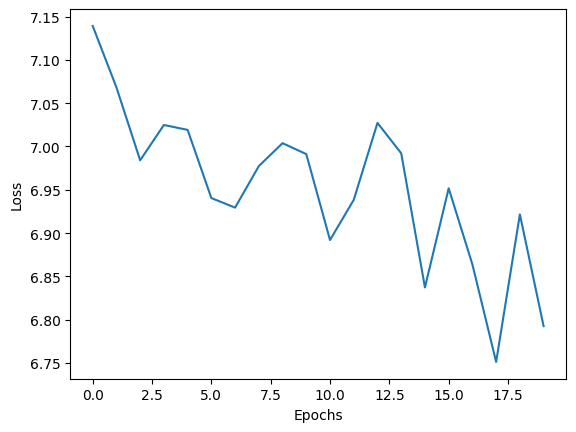

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses_no_q)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
model.wv["hello"].reshape(1, 1, -1)

array([[[-0.41517803, -0.4115109 ,  0.03152936, -0.39443275,
         -0.53960776,  0.29682222, -0.08886583,  0.28547296,
         -0.6235346 ,  0.3088295 ,  0.9159395 , -0.09112879,
          0.47189972,  0.04211483, -0.39875433,  0.4821917 ,
          0.51247317, -0.45832282, -0.05973277, -0.59387016,
          0.08640499,  0.19922154,  0.17756073,  0.2059553 ,
         -0.08161777, -0.17037144, -0.5597447 , -0.09343422,
         -0.3387001 , -0.20463543,  0.4914641 ,  0.28973857,
         -0.13604318,  0.9649771 , -0.21918458,  0.2747349 ,
         -0.06691943,  0.29347715,  0.19683653, -0.33182493,
          0.13217972,  0.24170078, -0.28193328,  0.524974  ,
          0.4507993 , -0.83715665,  0.31234008,  0.309225  ,
          0.02231254,  0.30755863]]], dtype=float32)

In [ ]:
max_length = 20

def sample(start_word):
    with torch.no_grad():
        input = model.wv[start_word].reshape(1, 1, -1)
        input = torch.from_numpy(input)
        hidden = rnn.initHidden()
        # print(hidden.shape)

        output_sentence = start_word + ' '

        for i in range(max_length):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == EOS_idx:
                break
            else:
                word = vocab[topi]
                output_sentence += word + ' '
            input = inputTensor(word)

        return output_sentence


In [ ]:
vocab[:10]

['><br', '<br', 'movie', 'film', '<num>', 'one', 'like', 'just', 'even', 'bad']

In [ ]:
sample("film")

'film ><br movie '

## RNN with quantization

In [ ]:
def get_quantized_vec(word):
    vec = list(model.wv[word])
    (cA, cD) = pywt.dwt(vec, 'db1')
    return np.array(cA).round(decimals=0)


In [ ]:
get_quantized_vec("movie").shape

(25,)

In [ ]:
vec = list(model.wv["><br"])
(cA, cD) = pywt.dwt(vec, 'db1')
print(model.wv["><br"])

[-0.01488521 -0.1788752  -0.4682187  -0.84848404 -0.7183219   0.6354621
 -0.06617253  0.8111203  -1.126337    0.36423874  1.3501596   0.33035973
  0.27433863 -0.44112128 -0.04730156  0.47897565  0.5224655  -0.68627554
  0.8701776  -0.6625273   0.0136292  -0.02909914 -0.17191164 -0.06798144
  0.09586425 -0.30543405 -0.6139605  -0.75081897 -0.3901858   0.35040453
  0.8119023   0.01065003 -0.09263629  1.3070788   0.8473332  -0.09467817
 -0.11096766  0.22863032  0.79896677  0.17568766  0.47247514  0.33245113
 -0.16864815  0.9094401   0.40976933 -1.0304965   0.8851629  -0.23213597
 -0.4878894   1.0562638 ]


In [ ]:
cA = list(np.array(cA).round(decimals=1))
cD = list(np.array(cD).round(decimals=1))
print(cA, cD)

[-0.1, -0.9, -0.1, 0.5, -0.5, 1.2, -0.1, 0.3, -0.1, 0.1, -0.0, -0.2, -0.1, -1.0, -0.0, 0.6, 0.9, 0.5, 0.1, 0.7, 0.6, 0.5, -0.4, 0.5, 0.4] [0.1, 0.3, -1.0, -0.6, -1.1, 0.7, 0.5, -0.4, 0.9, 1.1, 0.0, -0.1, 0.3, 0.1, -0.5, 0.6, -1.0, 0.7, -0.2, 0.4, 0.1, -0.8, 1.0, 0.8, -1.1]


In [ ]:
pywt.idwt(cA, cD, 'db1', 'smooth')

array([ 0.        , -0.14142136, -0.42426407, -0.84852814, -0.77781746,
        0.6363961 , -0.07071068,  0.77781746, -1.13137085,  0.42426407,
        1.34350288,  0.35355339,  0.28284271, -0.42426407, -0.07071068,
        0.49497475,  0.56568542, -0.70710678,  0.84852814, -0.70710678,
        0.        ,  0.        , -0.21213203, -0.07071068,  0.14142136,
       -0.28284271, -0.6363961 , -0.77781746, -0.35355339,  0.35355339,
        0.84852814,  0.        , -0.07071068,  1.34350288,  0.84852814,
       -0.14142136, -0.07071068,  0.21213203,  0.77781746,  0.21213203,
        0.49497475,  0.35355339, -0.21213203,  0.91923882,  0.42426407,
       -0.98994949,  0.91923882, -0.21213203, -0.49497475,  1.06066017])

In [57]:
def randomChoice(l):
    return l[np.random.randint(0, len(l) - 1)]


# Devuelve un tensor con los embeddings de las palabras que
# conforman dicho texto
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, embedding_dim//2)
    for li in range(len(line)):
        word = line[li]
        # print(word)
        tensor[li][0] = torch.from_numpy(get_quantized_vec(word))
    return tensor

# Devuelve el índice de la palabra objetivo para cada palabra de entrada
def targetTensor(line):
    letter_indexes = [vocab.index(line[li]) for li in range(1, len(line))]
    letter_indexes.append(EOS_idx) # EOS
    return torch.LongTensor(letter_indexes)

In [58]:
import torch.optim as optim

criterion = nn.NLLLoss()

learning_rate = 0.01


def train(input_line_tensor, target_line_tensor, l2_penalty=1e-3):

    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l


    loss.backward()
    rnn.quantize_gradients()
    # torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=1)
    optimizer.step()


    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)


    return output, loss.item() / input_line_tensor.size(0)

In [59]:
from tqdm import tqdm
rnn = RNN(embedding_dim//2, 128, vocab_size+1)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

rnn.apply(init_weights)

n_iters = 1000
print_every = 50
plot_every = 50
all_losses = []
total_loss = 0

start = time.time()

#Se implementa el método de optimización Adam, con regularización L2
#definida en la función optim.Adam por el parámetro weight_decay
optimizer = optim.Adam(rnn.parameters(), weight_decay=1e-5)

for iter in tqdm(range(1, n_iters + 1), desc=f"Training progress"):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    # print(loss)

    if iter % print_every == 0:
        print('\n%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


Training progress:   5%|▌         | 50/1000 [00:46<12:33,  1.26it/s]


0m 46s (50 5%) 7.4816


Training progress:  10%|█         | 100/1000 [01:31<12:39,  1.19it/s]


1m 31s (100 10%) 7.5002


Training progress:  15%|█▌        | 150/1000 [02:10<10:45,  1.32it/s]


2m 10s (150 15%) 6.7885


Training progress:  20%|██        | 200/1000 [02:51<07:44,  1.72it/s]


2m 51s (200 20%) 5.7197


Training progress:  25%|██▌       | 250/1000 [03:39<09:41,  1.29it/s]


3m 39s (250 25%) 6.8375


Training progress:  30%|███       | 300/1000 [04:29<12:04,  1.03s/it]


4m 29s (300 30%) 7.0051


Training progress:  35%|███▌      | 350/1000 [05:16<07:17,  1.49it/s]


5m 16s (350 35%) 6.9049


Training progress:  40%|████      | 400/1000 [06:04<10:08,  1.01s/it]


6m 4s (400 40%) 7.0563


Training progress:  45%|████▌     | 450/1000 [06:48<08:08,  1.13it/s]


6m 48s (450 45%) 6.4240


Training progress:  50%|█████     | 500/1000 [07:38<13:11,  1.58s/it]


7m 38s (500 50%) 6.8367


Training progress:  55%|█████▌    | 550/1000 [08:26<11:02,  1.47s/it]


8m 26s (550 55%) 5.9320


Training progress:  60%|██████    | 600/1000 [09:12<04:27,  1.50it/s]


9m 12s (600 60%) 6.5550


Training progress:  65%|██████▌   | 650/1000 [10:01<07:47,  1.33s/it]


10m 1s (650 65%) 5.2131


Training progress:  70%|███████   | 700/1000 [10:49<04:34,  1.09it/s]


10m 49s (700 70%) 7.3130


Training progress:  75%|███████▌  | 750/1000 [11:30<02:45,  1.51it/s]


11m 30s (750 75%) 6.5527


Training progress:  80%|████████  | 800/1000 [12:12<02:44,  1.22it/s]


12m 12s (800 80%) 7.4866


Training progress:  85%|████████▌ | 850/1000 [12:52<01:34,  1.59it/s]


12m 52s (850 85%) 7.2106


Training progress:  90%|█████████ | 900/1000 [13:37<01:17,  1.28it/s]


13m 37s (900 90%) 6.2253


Training progress:  95%|█████████▌| 950/1000 [14:16<00:34,  1.44it/s]


14m 16s (950 95%) 6.5331


Training progress: 100%|██████████| 1000/1000 [15:01<00:00,  1.11it/s]


15m 1s (1000 100%) 7.3180


Text(0, 0.5, 'Loss')

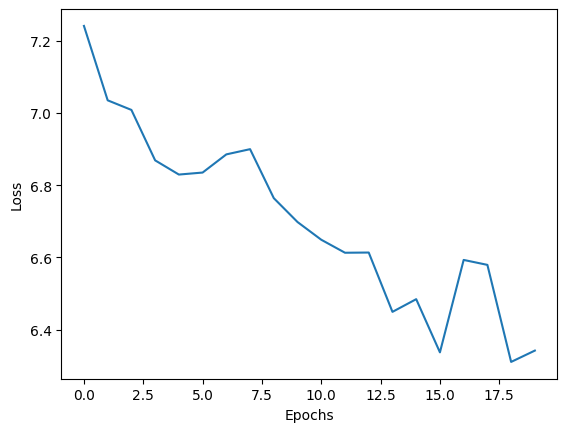

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [69]:
max_length = 20

def sample(start_word):
    with torch.no_grad():
        input = get_quantized_vec(start_word).reshape(1, 1, -1).astype('float32')
        input = torch.from_numpy(input)
        hidden = rnn.initHidden()
        # print(hidden.shape)

        output_sentence = start_word + ' '

        for i in range(max_length):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == EOS_idx:
                break
            else:
                word = vocab[topi]
                output_sentence += word + ' '
            input = inputTensor(word)

        return output_sentence


In [68]:
model.wv['hello'].dtype

dtype('float32')

In [70]:
sample("movie")

'movie film <br <br foxx <br <br chronicles accent accent accent movie <br <br <br <br chronicles <br <br movie <br '

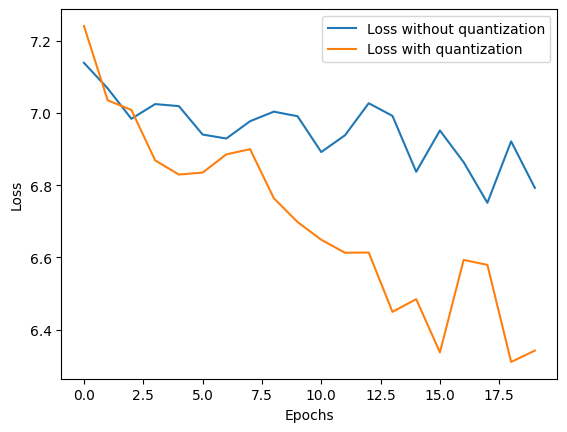

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
l1 = plt.plot(all_losses_no_q)
l2 = plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss without quantization','Loss with quantization'], loc = 'best')
plt.show()